In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
import os
import numpy as np
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt

# Path to the folders containing images and masks
image_folder = "/content/gdrive/MyDrive/ORGINAL_img"
mask_folder = "/content/gdrive/MyDrive/ORIGINAL_mask"

# Get the list of image and mask filenames
image_filenames = sorted(os.listdir(image_folder))
mask_filenames = sorted(os.listdir(mask_folder))

# Data normalization function
def normalize_data(data):
    return data / 255.0

# Initialize empty lists to store normalized images and masks
normalized_images = []
normalized_masks = []

# Iterate over the image and mask filenames
for i in range(len(image_filenames)):
    # Load image and mask
    image_filename = os.path.join(image_folder, image_filenames[i])
    mask_filename = os.path.join(mask_folder, mask_filenames[i])
    image = cv2.imread(image_filename)
    mask = cv2.imread(mask_filename, cv2.IMREAD_GRAYSCALE)
    new_size = (384, 96)
    image_resized = cv2.resize(image, new_size)
    mask_resized = cv2.resize(mask, new_size)
    # Normalize image and mask
    normalized_image = normalize_data(image_resized)
    normalized_mask = normalize_data(mask_resized)
    # Binarize the mask (optional)
    normalized_mask = np.where(normalized_mask > 0.5, 1, 0)

    # Append normalized images and masks to the respective lists
    normalized_images.append(normalized_image)
    normalized_masks.append(normalized_mask)

# Convert the image and mask lists to numpy arrays
normalized_images = np.array(normalized_images)
normalized_masks = np.array(normalized_masks)

# VGG-UNet model for semantic segmentation
def vgg_unet():
    # Load pre-trained VGG16 model
    vgg_model = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(96, 384, 3))

    # Encoder (VGG16 layers)
    encoder = vgg_model.get_layer('block5_conv3').output

    # Decoder (UNet layers)
    decoder = keras.layers.Conv2DTranspose(512, 3, strides=(2, 2), padding='same')(encoder)
    decoder = keras.layers.concatenate([decoder, vgg_model.get_layer('block4_conv3').output], axis=3)
    decoder = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(decoder)
    decoder = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(decoder)

    decoder = keras.layers.Conv2DTranspose(256, 3, strides=(2, 2), padding='same')(decoder)
    decoder = keras.layers.concatenate([decoder, vgg_model.get_layer('block3_conv3').output], axis=3)
    decoder = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(decoder)
    decoder = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(decoder)

    decoder = keras.layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(decoder)
    decoder = keras.layers.concatenate([decoder, vgg_model.get_layer('block2_conv2').output], axis=3)
    decoder = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(decoder)
    decoder = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(decoder)

    decoder = keras.layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(decoder)
    decoder = keras.layers.concatenate([decoder, vgg_model.get_layer('block1_conv2').output], axis=3)
    decoder = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(decoder)
    decoder = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(decoder)

    # Output
    output = keras.layers.Conv2D(1, 1, activation='sigmoid')(decoder)

    # Create the model
    model = keras.models.Model(inputs=vgg_model.input, outputs=output)

    return model

# Create the VGG-UNet model
model = vgg_unet()


58889256/58889256 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 29ms/step


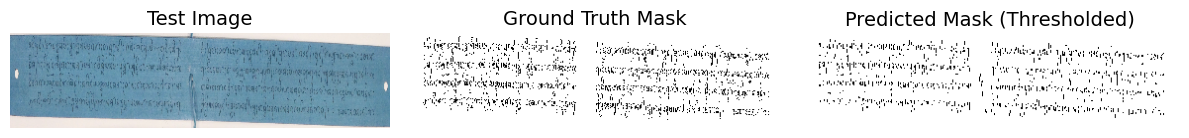

PSNR: 391.09704627107897
DRD: 0.5691788577940812
IoU: 0.9318048206937096
SSIM: 1.0


In [ ]:
import skimage.metrics as metrics

# Load the trained weights
model.load_weights('/content/gdrive/MyDrive/thresholded encoded.h5')

# Choose the index of the image you want to test
image_index = 10

# Get the corresponding test image and mask
test_image = normalized_images[image_index]
test_mask = normalized_masks[image_index]

# Convert the test image and mask to numpy arrays
test_images = np.expand_dims(test_image, axis=0)
test_masks = np.expand_dims(test_mask, axis=0)

# Make predictions on the test image
predictions = model.predict(test_images)

# Apply threshold to the predicted mask
threshold = 0.5
predicted_mask = np.where(predictions > threshold, 1, 0)

# Display the test image, ground truth mask, and predicted mask
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Test Image", fontsize=14)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(test_mask, cmap='gray')
plt.title("Ground Truth Mask", fontsize=14)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask (Thresholded)", fontsize=14)
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the ground truth mask
plt.imsave("ground_truth_mask.png", test_mask, cmap='gray')

# Save the predicted mask
plt.imsave("predicted_mask.png", predicted_mask.squeeze(), cmap='gray')

# Calculate PSNR
psnr = metrics.peak_signal_noise_ratio(test_mask, predicted_mask.squeeze())

# Calculate DRD
drd = metrics.structural_similarity(test_mask, predicted_mask.squeeze(), data_range=1.0)

# Calculate IoU (Jaccard Index)
intersection = np.logical_and(test_mask, predicted_mask.squeeze())
union = np.logical_or(test_mask, predicted_mask.squeeze())
iou = np.sum(intersection) / np.sum(union)

# Calculate SSIM
ssim = metrics.structural_similarity(test_mask, predicted_mask.squeeze(), channel_axis=None)

print("PSNR:", psnr)
print("DRD:", drd)
print("IoU:", iou)
print("SSIM:", ssim)


1/1 [==============================] - 0s 241ms/step


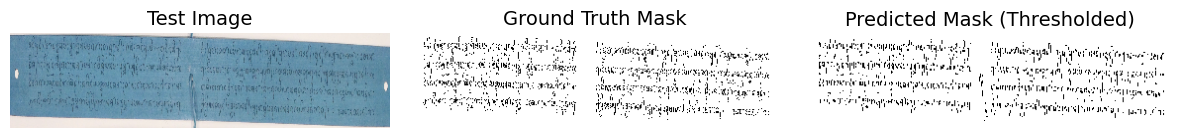

Precision: [0.923801   0.96185167 1.        ]
Recall: [1.         0.96766995 0.        ]
F1 Score: [0.96039143 0.96475203 0.        ]
AUC: 0.7511899034183338
Mean Average Precision (mAP): 0.9606214878552743
Peak Signal-to-Noise Ratio (PSNR): 11.849459748213123
Dynamic Range Difference (DRD): 0.06532118055555555
Intersection-over-Union (IoU): 0.9319043040552005
Structural Similarity (SSIM): 1.0


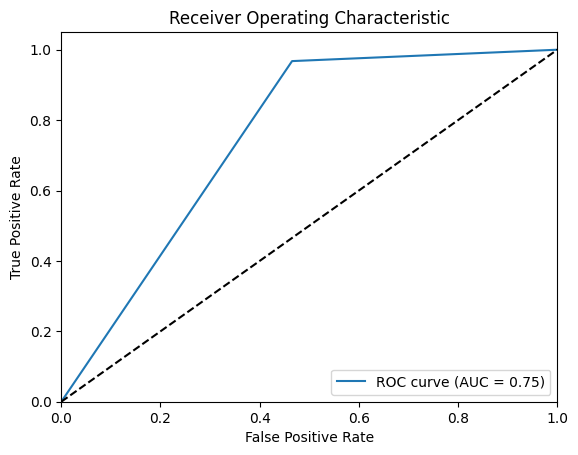

In [ ]:
import os
import numpy as np
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from skimage.metrics import structural_similarity

# Path to the folders containing images and masks
image_folder = "/content/gdrive/MyDrive/ORGINAL_img"
mask_folder = "/content/gdrive/MyDrive/ORIGINAL_mask"

# Get the list of image and mask filenames
image_filenames = sorted(os.listdir(image_folder))
mask_filenames = sorted(os.listdir(mask_folder))

# Data normalization function
def normalize_data(data):
    return data / 255.0

# Initialize empty lists to store normalized images and masks
normalized_images = []
normalized_masks = []

# Iterate over the image and mask filenames
for i in range(len(image_filenames)):
    # Load image and mask
    image_filename = os.path.join(image_folder, image_filenames[i])
    mask_filename = os.path.join(mask_folder, mask_filenames[i])
    image = cv2.imread(image_filename)
    mask = cv2.imread(mask_filename, cv2.IMREAD_GRAYSCALE)
    new_size = (384, 96)
    image_resized = cv2.resize(image, new_size)
    mask_resized = cv2.resize(mask, new_size)
    # Normalize image and mask
    normalized_image = normalize_data(image_resized)
    normalized_mask = normalize_data(mask_resized)
    # Binarize the mask (optional)
    normalized_mask = np.where(normalized_mask > 0.5, 1, 0)

    # Append normalized images and masks to the respective lists
    normalized_images.append(normalized_image)
    normalized_masks.append(normalized_mask)

# Convert the image and mask lists to numpy arrays
normalized_images = np.array(normalized_images)
normalized_masks = np.array(normalized_masks)

# Load the trained model
model = keras.models.load_model('/content/gdrive/MyDrive/thresholded encoded.h5')

# Choose the index of the image you want to test
image_index = 10

# Get the corresponding test image and mask
test_image = normalized_images[image_index]
test_mask = normalized_masks[image_index]

# Convert the test image and mask to numpy arrays
test_images = np.expand_dims(test_image, axis=0)
test_masks = np.expand_dims(test_mask, axis=0)

# Make predictions on the test image
predictions = model.predict(test_images)

# Apply threshold to the predicted mask
threshold = 0.6
predicted_mask = np.where(predictions > threshold, 1, 0)

# Display the test image, ground truth mask, and predicted mask
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Test Image", fontsize=14)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(test_mask, cmap='gray')
plt.title("Ground Truth Mask", fontsize=14)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask (Thresholded)", fontsize=14)
plt.axis("off")

plt.tight_layout()
plt.show()

# Save the ground truth mask
plt.imsave("ground_truth_mask.png", test_mask, cmap='gray')

# Save the predicted mask
plt.imsave("predicted_mask.png", predicted_mask.squeeze(), cmap='gray')

# Flatten the ground truth mask and predicted mask
ground_truth_mask_flat = test_mask.flatten()
predicted_mask_flat = predicted_mask.squeeze().flatten()

# Calculate precision, recall, and F1 score
precision, recall, _ = precision_recall_curve(ground_truth_mask_flat, predicted_mask_flat)
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(ground_truth_mask_flat, predicted_mask_flat)
roc_auc = auc(fpr, tpr)

# Calculate mAP
ap = average_precision_score(ground_truth_mask_flat, predicted_mask_flat)

# Calculate PSNR
def calculate_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    max_pixel = 1.0  # Assuming pixel values are in the range [0, 1]
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Calculate DRD
def calculate_drd(y_true, y_pred):
    drd = np.mean(np.abs(y_true - y_pred))
    return drd

# Calculate IoU
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Calculate SSIM
def calculate_ssim(y_true, y_pred):
    ssim = structural_similarity(y_true, y_pred)
    return ssim

# Calculate evaluation metrics
psnr = calculate_psnr(test_mask, predicted_mask.squeeze())
drd = calculate_drd(test_mask, predicted_mask.squeeze())
iou = calculate_iou(test_mask, predicted_mask.squeeze())
ssim = calculate_ssim(test_mask, predicted_mask.squeeze())

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", roc_auc)
print("Mean Average Precision (mAP):", ap)
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)
print("Dynamic Range Difference (DRD):", drd)
print("Intersection-over-Union (IoU):", iou)
print("Structural Similarity (SSIM):", ssim)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
